# Create CIFAR2 Data loader

In [1]:
import torch
from torch.utils.data import Dataset
import os
import torchvision
from torchvision.transforms import transforms
import pandas as pd
import numpy as np
from PIL import Image


class CIFAR2(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.class_name = {0: "ants", 1: "bees"}

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        label = self.img_labels.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, self.class_name[int(label)], self.img_labels.iloc[idx, 0])
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return img, label

In [19]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [20]:
train_annotations_file = "./data/hymenoptera_data/annotation_train.csv"
train_img_dir = "./data/hymenoptera_data/train"
train_dataset = CIFAR2(train_annotations_file, train_img_dir, transform = data_transforms["train"])



In [21]:
from torch.utils.data import DataLoader
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))

In [22]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


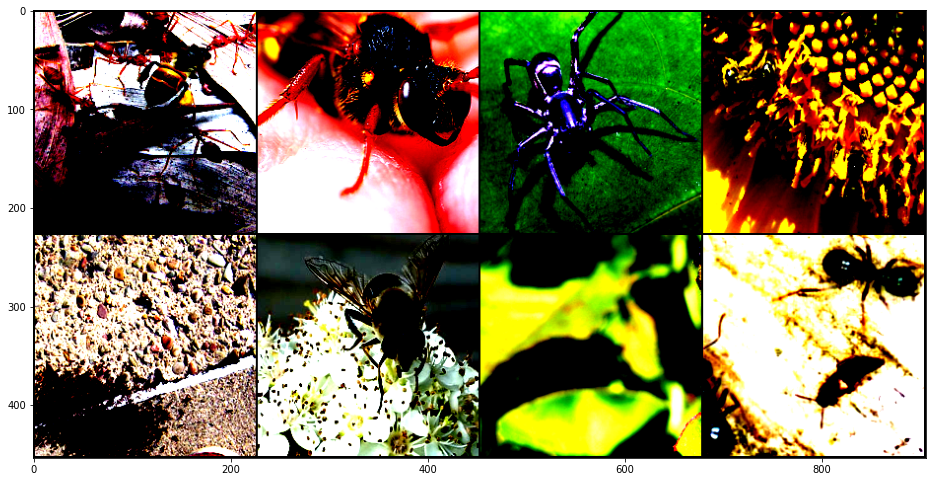

In [23]:
imshow(torchvision.utils.make_grid(train_features, 4))

In [24]:
train_features.shape

torch.Size([8, 3, 224, 224])

In [25]:
class_name = {0: "ants", 1: "bees"}
print([class_name[id][:-1] for id in train_labels.numpy()])

['ant', 'bee', 'ant', 'bee', 'ant', 'bee', 'bee', 'ant']


In [26]:
val_annotations_file = "./data/hymenoptera_data/annotation_val.csv"
val_img_dir = "./data/hymenoptera_data/val"
val_dataset = CIFAR2(train_annotations_file, train_img_dir, transform = data_transforms["val"])



In [27]:
val_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_features, val_labels = next(iter(val_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


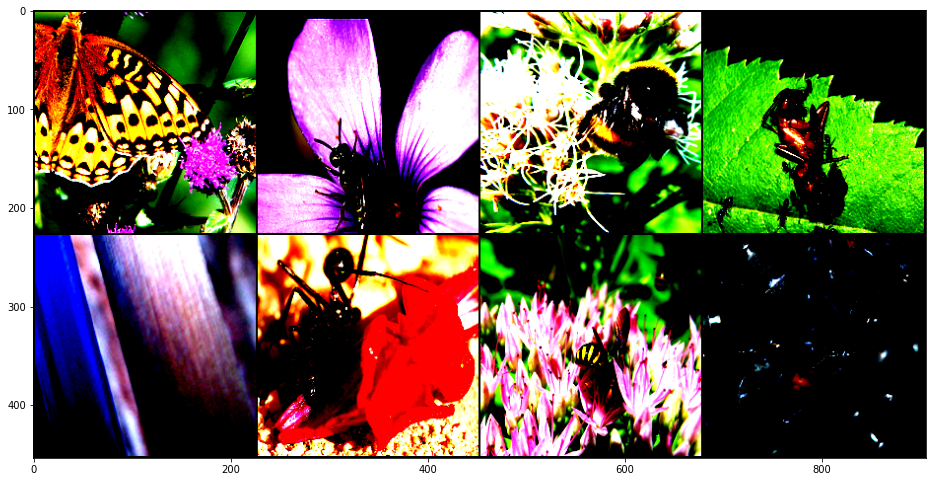

In [42]:
imshow(torchvision.utils.make_grid(val_features, 4))

In [43]:
print([class_name[id][:-1] for id in val_labels.numpy()])

['bee', 'bee', 'bee', 'ant', 'ant', 'ant', 'bee', 'ant']


In [44]:
dataset_sizes = {"train" : len(train_dataset), "val" : len(val_dataset)}

In [45]:
val_features.shape

torch.Size([8, 3, 224, 224])

## Build Network

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [47]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() 

In [48]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Load Pretrained Network

In [49]:
import torchvision

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [50]:
dataloaders = {"train": train_dataloader, "val": val_dataloader}

# Fine tuning model

In [51]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5276 Acc: 0.7265
val Loss: 0.1856 Acc: 0.9388

Epoch 1/24
----------
train Loss: 0.2619 Acc: 0.8816
val Loss: 0.1979 Acc: 0.9347

Epoch 2/24
----------
train Loss: 0.2765 Acc: 0.8939
val Loss: 0.2519 Acc: 0.8816

Epoch 3/24
----------
train Loss: 0.3116 Acc: 0.8653
val Loss: 0.0949 Acc: 0.9592

Epoch 4/24
----------
train Loss: 0.1602 Acc: 0.9469
val Loss: 0.0872 Acc: 0.9592

Epoch 5/24
----------
train Loss: 0.2092 Acc: 0.9143
val Loss: 0.1258 Acc: 0.9429

Epoch 6/24
----------
train Loss: 0.1122 Acc: 0.9592
val Loss: 0.0418 Acc: 0.9837

Epoch 7/24
----------
train Loss: 0.2563 Acc: 0.8939
val Loss: 0.0711 Acc: 0.9714

Epoch 8/24
----------
train Loss: 0.1347 Acc: 0.9388
val Loss: 0.0430 Acc: 0.9837

Epoch 9/24
----------
train Loss: 0.1972 Acc: 0.9306
val Loss: 0.0534 Acc: 0.9796

Epoch 10/24
----------
train Loss: 0.2293 Acc: 0.9061
val Loss: 0.0734 Acc: 0.9673

Epoch 11/24
----------
train Loss: 0.0869 Acc: 0.9633
val Loss: 0.0544 Acc: 0.9837

Ep

In [49]:
model_ft = models.resnet18(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  